# Conformal Regression (Built on top of DER)
Romano+'s approach to quantile regression, these are heuristic.
Turn this into a score function, which we then calibrate with conformal prediction

In [1]:
import torch
import functools
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis, evaluate_uncert

In [3]:
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)

In [4]:
DEVICE = get_best_device()

In [5]:
DER_TYPE = 'DER'  # 'sDER'
norm = 'False' # if you normalize, rn the normalized version doesn't work

In [6]:
BATCH_SIZE = 100
N_SAMPLES = 50
N_EPOCHS = 500

if DER_TYPE == 'DER':
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
else:
    LR = .005    # learning rate
    COEFF = 2.   # lambda

In [7]:
if DER_TYPE == 'DER':
    DERLayer = models.DERLayer
    loss_der = models.loss_der
else:
    DERLayer = models.SDERLayer
    loss_der = models.loss_sder

## Generate data
This is the same as in the DeepEnsemble

In [8]:
# same simulator as in likelihood-based inference,
# but here we have 
def simulator(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size = len(x_data)) 
    return m * x_data + b + ε

def simulator_no_noise(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    return m * x_data + b

In [9]:
x_data = np.linspace(0, 100, 101)

length_df = 1000
#ms = np.zeros((length_df, 101))
ms_list = []#np.zeros((length_df, 1))
bs_list = []#np.zeros((length_df, 1))
ys_list = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.uniform(low=0, high=10)
    b = rs.uniform(low=-10, high=10)    
    ms_list.append(m)
    bs_list.append(b)
    '''
    xs[r,:] = thetas_1d[0]#np.linspace(0, 100, 101)
    ms[r,:] = thetas_1d[1]#np.repeat(thetas_1d[0], 101)
    bs[r,:] = thetas_1d[2]#np.repeat(thetas_1d[1], 101)
    sigmas[r,:] = thetas_1d[3]#np.repeat(thetas_1d[2], 101)
    '''
    ys_list.append(simulator([m,b]))
ms_array = np.repeat(ms_list, len(x_data))
bs_array = np.repeat(bs_list, len(x_data))
xs_array = np.tile(x_data, length_df)
ys_array = np.reshape(ys_list, (length_df * len(x_data)))

<Figure size 640x480 with 0 Axes>

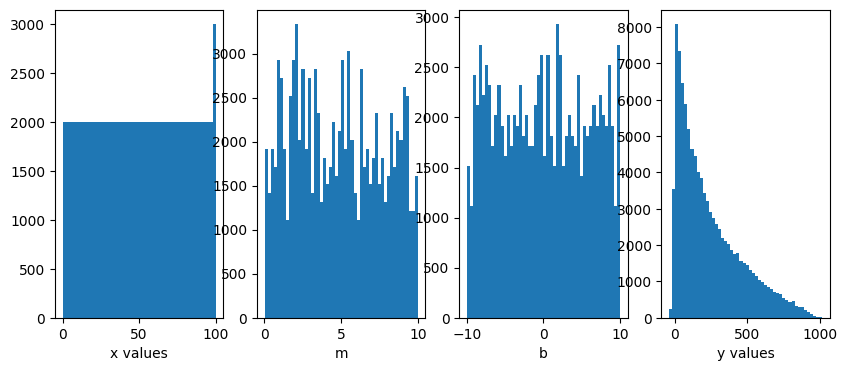

In [10]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

In [11]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [12]:
if norm == 'True':
    print('normalized version', norm)
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    print('not normalizing')
    model_inputs = inputs
    model_outputs = ys_array

not normalizing


<Figure size 640x480 with 0 Axes>

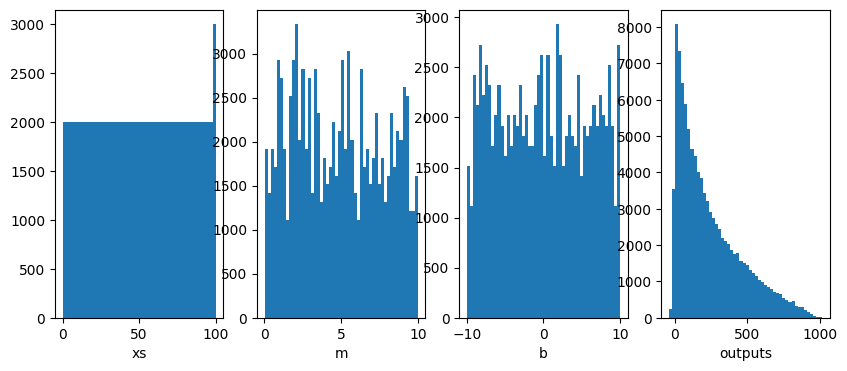

In [13]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

(90900, 3) (90900,)
(3,)


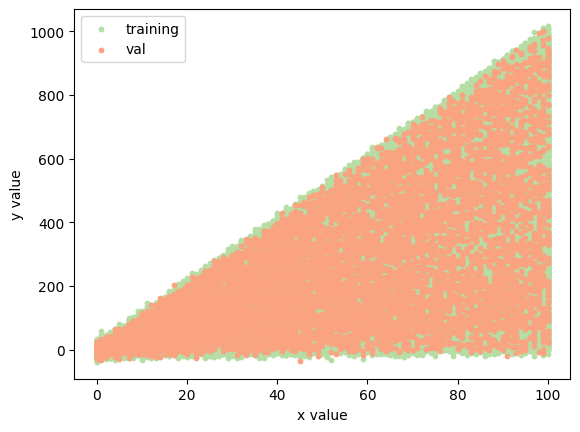

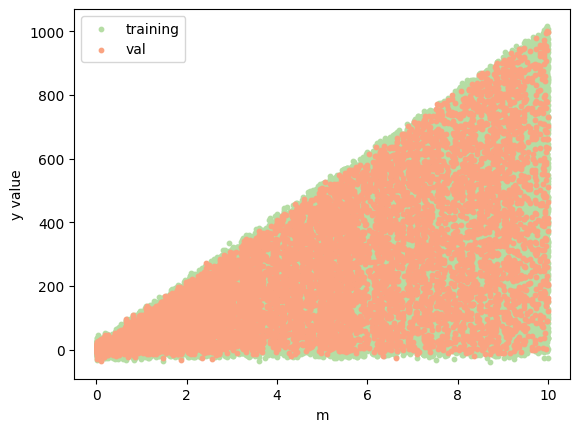

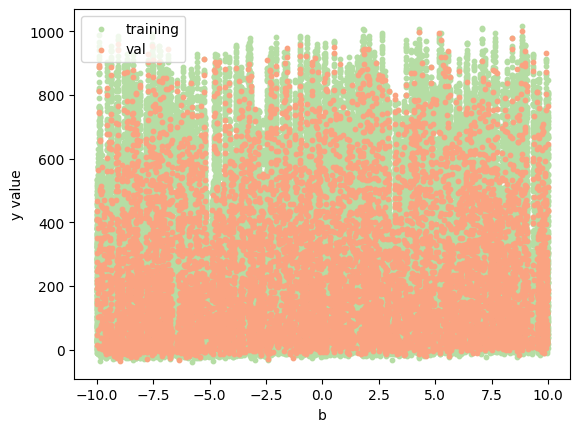

In [14]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [15]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0


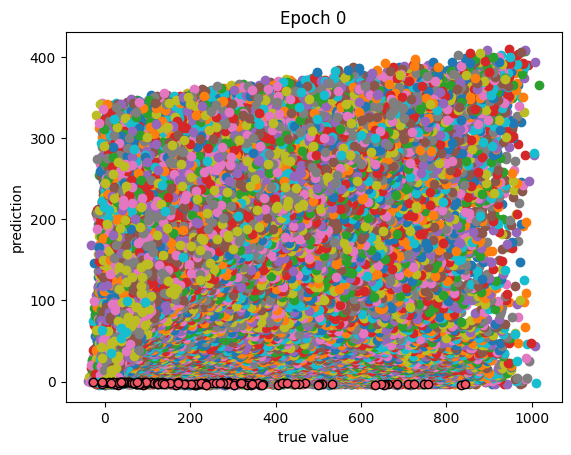

new best loss 7.19603967666626 in epoch 0
epoch 1 0.01
new best loss 5.5805888175964355 in epoch 1
epoch 2 0.02
new best loss 4.940151214599609 in epoch 2
epoch 3 0.03
new best loss 4.680994510650635 in epoch 3
epoch 4 0.04
new best loss 4.5105156898498535 in epoch 4
epoch 5 0.05


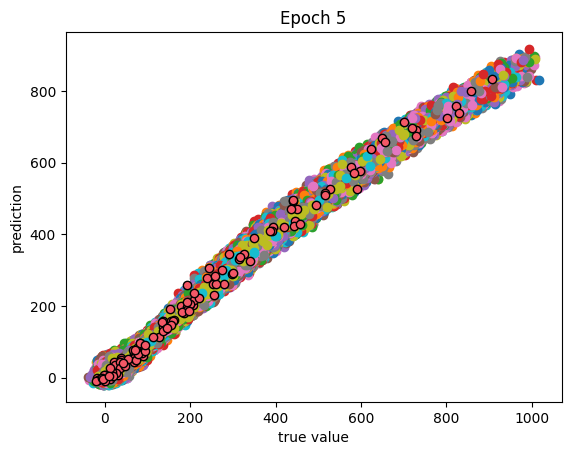

new best loss 4.368646621704102 in epoch 5
epoch 6 0.06
new best loss 4.245871543884277 in epoch 6
epoch 7 0.07
new best loss 4.138855934143066 in epoch 7
epoch 8 0.08
new best loss 4.071045398712158 in epoch 8
epoch 9 0.09
new best loss 4.035037994384766 in epoch 9
epoch 10 0.1


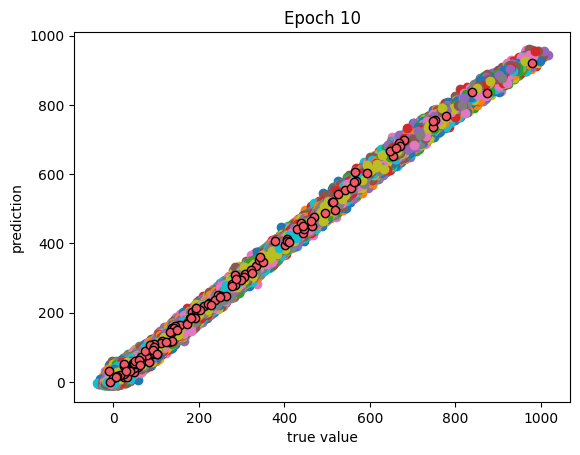

new best loss 4.027397632598877 in epoch 10
epoch 11 0.11
new best loss 3.981320858001709 in epoch 11
epoch 12 0.12
epoch 13 0.13
new best loss 3.953333854675293 in epoch 13
epoch 14 0.14
new best loss 3.9460809230804443 in epoch 14
epoch 15 0.15


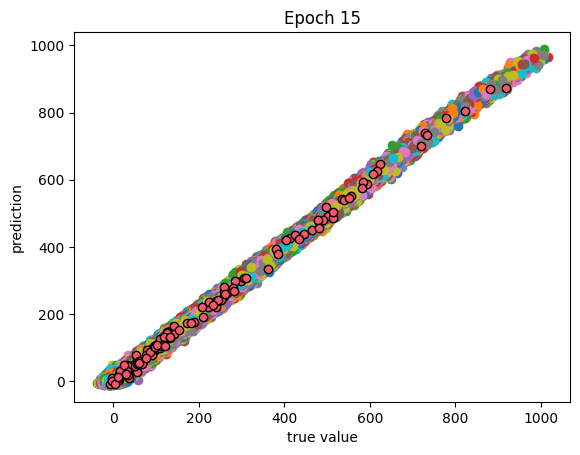

epoch 16 0.16
new best loss 3.931349039077759 in epoch 16
epoch 17 0.17
epoch 18 0.18
epoch 19 0.19
epoch 20 0.2


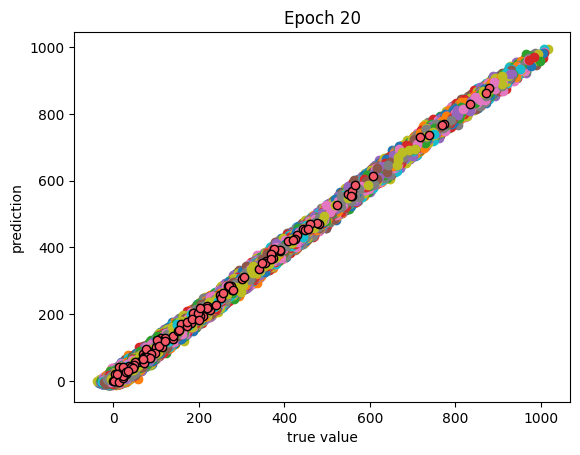

new best loss 3.929788827896118 in epoch 20
epoch 21 0.21
new best loss 3.9274539947509766 in epoch 21
epoch 22 0.22
epoch 23 0.23
new best loss 3.915464162826538 in epoch 23
epoch 24 0.24
epoch 25 0.25


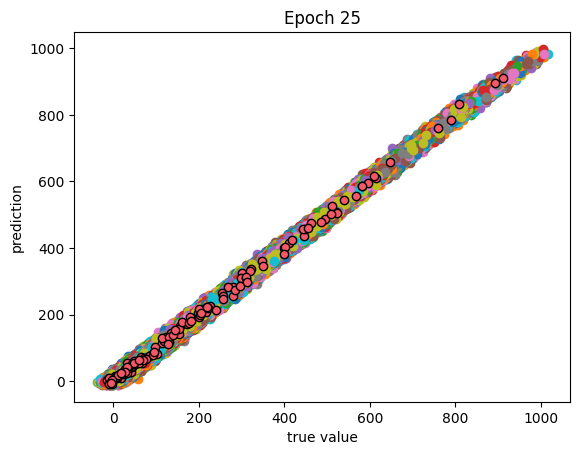

epoch 26 0.26
new best loss 3.912200689315796 in epoch 26
epoch 27 0.27
new best loss 3.910386800765991 in epoch 27
epoch 28 0.28
epoch 29 0.29
new best loss 3.9026036262512207 in epoch 29
epoch 30 0.3


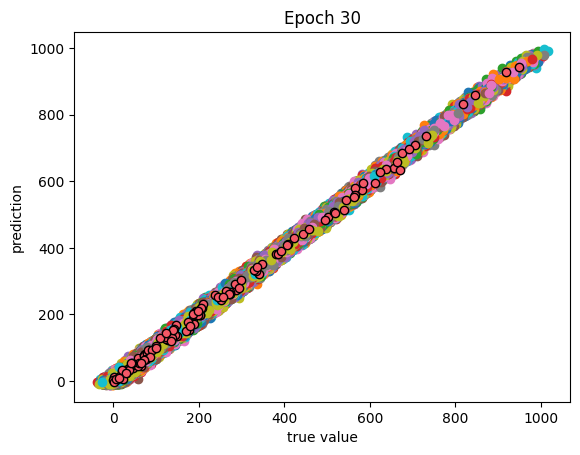

epoch 31 0.31
epoch 32 0.32
epoch 33 0.33
epoch 34 0.34
epoch 35 0.35


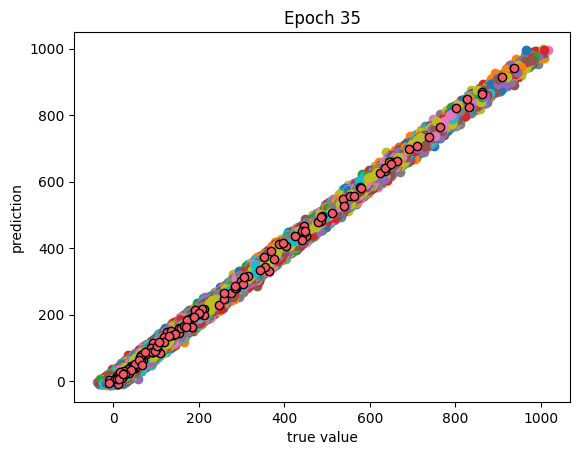

epoch 36 0.36
epoch 37 0.37
new best loss 3.901733875274658 in epoch 37
epoch 38 0.38
epoch 39 0.39
epoch 40 0.4


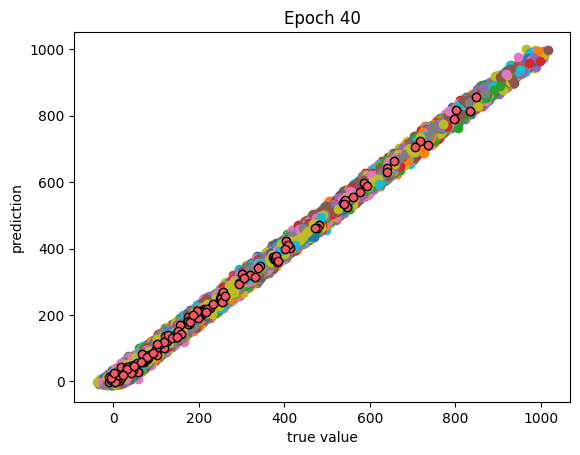

epoch 41 0.41
epoch 42 0.42
epoch 43 0.43
epoch 44 0.44
epoch 45 0.45


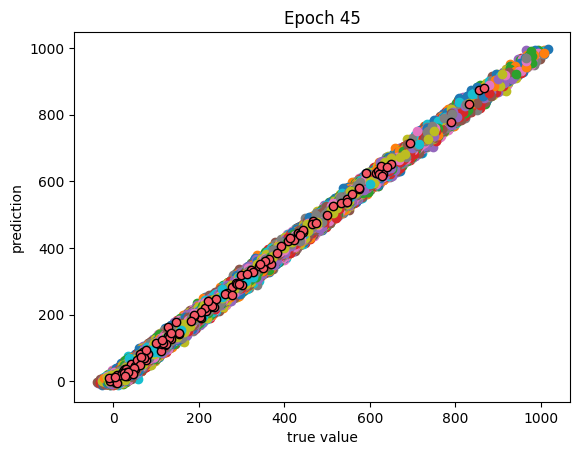

epoch 46 0.46
epoch 47 0.47
epoch 48 0.48
new best loss 3.898848533630371 in epoch 48
epoch 49 0.49
epoch 50 0.5


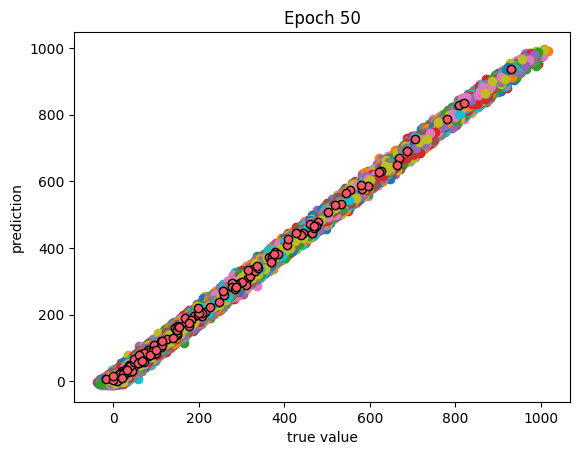

epoch 51 0.51
epoch 52 0.52
epoch 53 0.53
new best loss 3.8964333534240723 in epoch 53
epoch 54 0.54
epoch 55 0.55


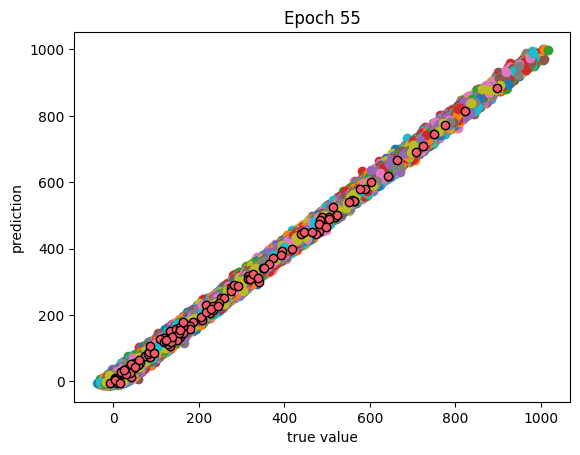

epoch 56 0.56
epoch 57 0.57
epoch 58 0.58
epoch 59 0.59
epoch 60 0.6


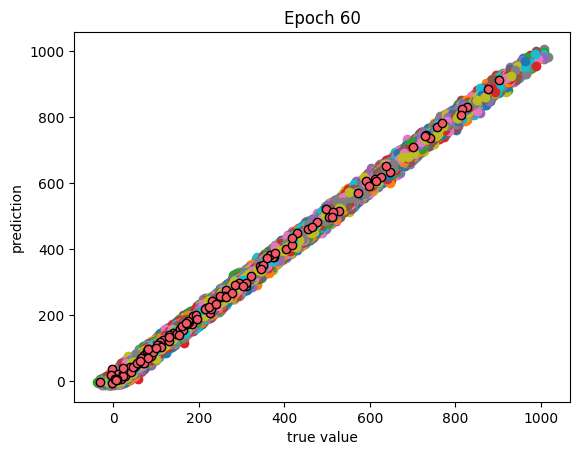

epoch 61 0.61
epoch 62 0.62
epoch 63 0.63
epoch 64 0.64
epoch 65 0.65


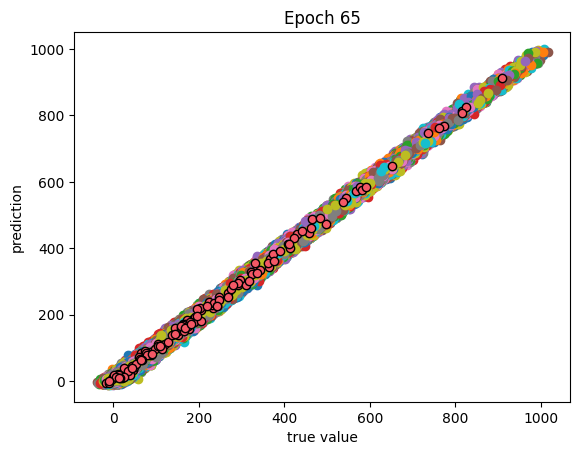

epoch 66 0.66
epoch 67 0.67
epoch 68 0.68
epoch 69 0.69
epoch 70 0.7


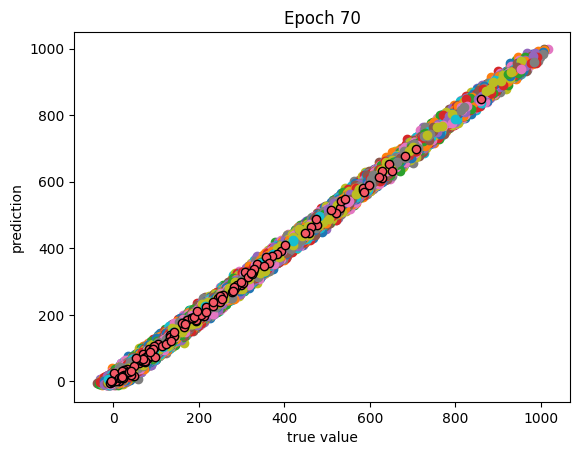

new best loss 3.895136833190918 in epoch 70
epoch 71 0.71
epoch 72 0.72
epoch 73 0.73
epoch 74 0.74
epoch 75 0.75


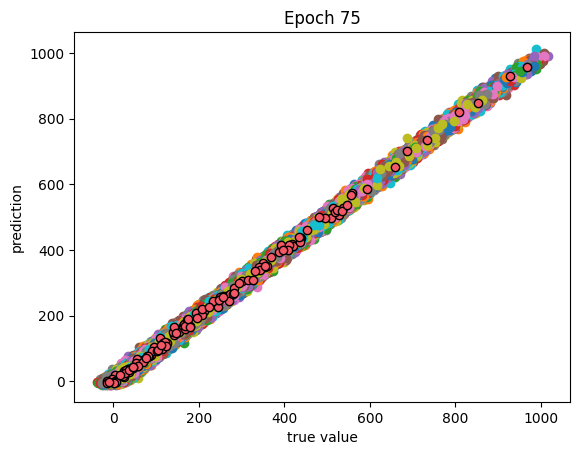

new best loss 3.8922038078308105 in epoch 75
epoch 76 0.76
epoch 77 0.77
epoch 78 0.78
epoch 79 0.79
epoch 80 0.8


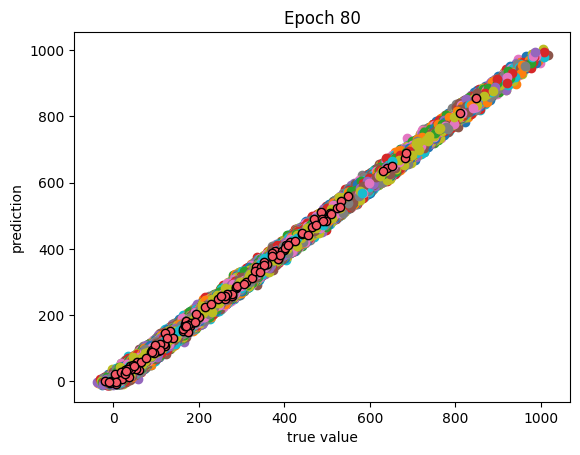

epoch 81 0.81
epoch 82 0.82
epoch 83 0.83
epoch 84 0.84
epoch 85 0.85


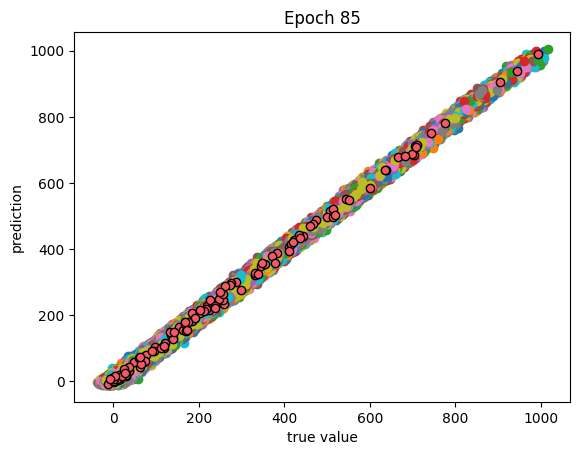

epoch 86 0.86
epoch 87 0.87
epoch 88 0.88
epoch 89 0.89
epoch 90 0.9


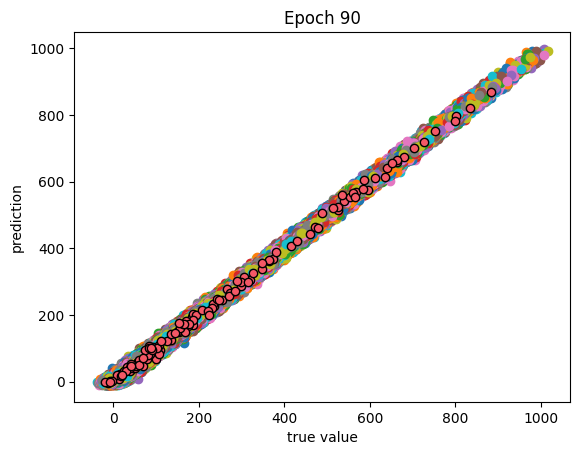

epoch 91 0.91
epoch 92 0.92
epoch 93 0.93
epoch 94 0.94
epoch 95 0.95


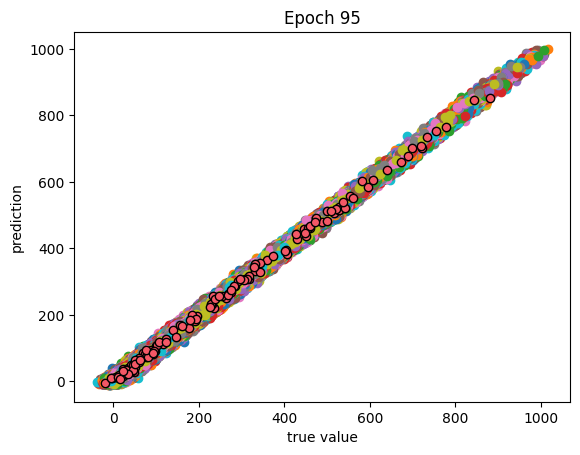

epoch 96 0.96
epoch 97 0.97
epoch 98 0.98
epoch 99 0.99
start at 1704823064.887488 end at 1704823162.040784
97.15329599380493


<Figure size 640x480 with 0 Axes>

In [16]:
# my own training model
DER_type = 'DER'
INIT_LR = LR
model = train.train_DER(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             DEVICE,
             COEFF,
             DER_type,
             model_name='DER',
             EPOCHS=100,
             save_checkpoints=False,
             plot=True)
 

### Compute the uncertainty
The original aleatoric and epistemic uncertainty (from OG paper):
$u_{al} = \sqrt{\frac{\beta_i}{(\alpha_i-1)}}$; $u_{ep} = \sqrt{\frac{\beta_i}{v_i(\alpha_i-1)}}$

The revised aleatoric and epistemic uncertainty:
$u_{al} = \sqrt{\frac{\beta_i (1+v_i)}{\alpha_i v_i}}$; $u_{ep} = \frac{1}{\sqrt{v_i}}$

The order of the parameters for a normal-inverse-gamma distribution is:
$$m = (\gamma, \nu, \alpha, \beta)$$

### Plot the aleatoric errors by data point

In [17]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use the NN to make a prediction
model.eval()
# first, normalize the x value using the xmin and xmax before
if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
    # I think I'm doing the un-normalization wrong for the other terms in the output:
    aleatoric_OG = np.sqrt((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) - 1))
    aleatoric_mod = np.sqrt(((y_norm_pred[:,3] * (outputmax - outputmin) + outputmin) * (1 + (y_norm_pred[:,1] * (outputmax - outputmin) + outputmin))) / ((y_norm_pred[:,2]* (outputmax - outputmin) + outputmin) * (y_norm_pred[:,1]* (outputmax - outputmin) + outputmin)))
    epistemic_OG = np.sqrt(y_norm_pred[:,3] / (y_norm_pred[:,1]*(y_norm_pred[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_norm_pred[:,1])
else:
    y_pred_all_terms = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    # now un-normalize this so you can plot it
    
    
    y_pred = y_pred_all_terms[:,0]
    aleatoric_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,2] - 1))
    aleatoric_mod = np.sqrt((y_pred_all_terms[:,3]  * (1 + y_pred_all_terms[:,1] )) / (y_pred_all_terms[:,2] * y_pred_all_terms[:,1]))
    epistemic_OG = np.sqrt(y_pred_all_terms[:,3] / (y_pred_all_terms[:,1]*(y_pred_all_terms[:,2] - 1)))
    epistemic_mod = 1 / np.sqrt(y_pred_all_terms[:,1])

<Figure size 640x480 with 0 Axes>

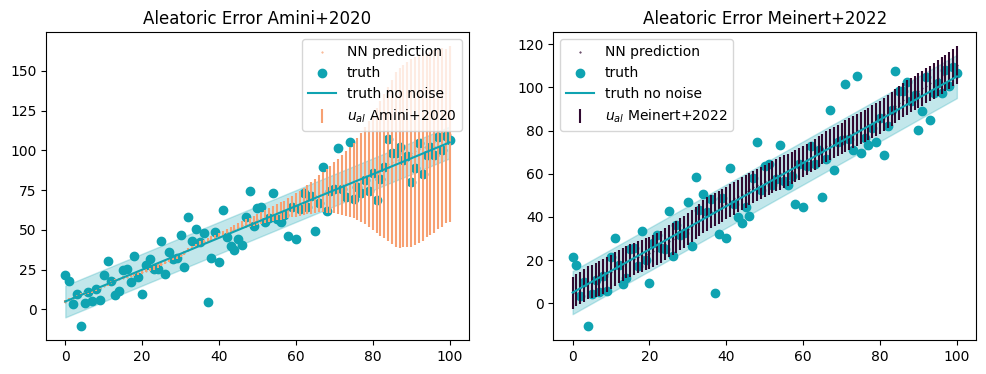

In [18]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = aleatoric_OG,
             label = r'$u_{al}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax1.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax1.set_title('Aleatoric Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = aleatoric_mod,
             label = r'$u_{al}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
ax2.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.25)

plt.legend()
ax2.set_title('Aleatoric Error Meinert+2022')
plt.show()

### Now epistemic

In [ ]:
print, epistemic_OG, epistemic_mod 

<Figure size 640x480 with 0 Axes>

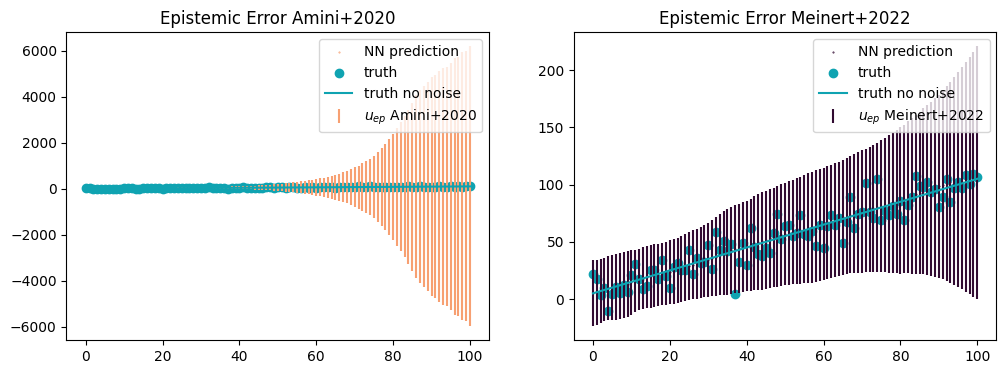

In [19]:
# plot
plt.clf()
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax1.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072', s = 0.2)
ax1.errorbar(x_data, y_pred, yerr = epistemic_OG,
             label = r'$u_{ep}$ Amini+2020', color = '#F7A072',
             ls = 'None')
ax1.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax1.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax1.set_title('Epistemic Error Amini+2020')

ax2 = fig.add_subplot(122)
# now plot the prediction from the NN
ax2.scatter(x_data, y_pred, label = 'NN prediction', color = '#310A31', s = 0.2)
ax2.errorbar(x_data, y_pred, yerr = epistemic_mod,
             label = r'$u_{ep}$ Meinert+2022', color = '#310A31',
             ls = 'None')
ax2.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
ax2.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
ax2.set_title('Epistemic Error Meinert+2022')
plt.show()


### Now that intervals are obtained we can apply conformalization
First trying this with the Meinert+2022 aleatoric uncertainty.

In [22]:
conf = evaluate_uncert.ConformalPredictor(model)
prediction_sets = conf.conformal_intervals(thetas_1d_true,
                            y_true,
                            y_pred,
                            aleatoric_mod,
                            0.32)

Guaranteeing 68.0% coverage


### Compare predicted uncertainty with true uncertainty
Using Spearman's rank coefficient.

In [27]:
spear = evaluate_uncert.SpearmanRankCalculator()
print(spear.calculate_spearman_rank(y_pred, y_true))
spear.calculate_spearman_rank(aleatoric_mod, np.repeat(10,len(aleatoric_mod)))

0.9432615026208502


nan